# Image classification using pretrained Resnet-18 and PyTorch

Image classification using STL-10 dataset, which includes 10 classes of images: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck.


# Importing Libraries

In [1]:
%matplotlib inline
import os
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Reading class names

In [2]:
from numpy import loadtxt

class_names = []
class_file = open("./STL10/data/stl10_binary/class_names.txt", "r")
line = class_file.readline()
while (line != ''):  # breaks when EOF is reached
    class_names.append(line.strip())
    line = class_file.readline()

print(class_names)

['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


# Creating Custom Dataset

In [3]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform, class_names):
        def get_images(class_label, class_name):
            images = [x for x in os.listdir(image_dirs[class_label]) if x.lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.image_dirs = image_dirs
        self.transform = transform
        self.class_names = class_names
        self.class_labels = range(1, len(class_names)+1)
        
        self.images = {}
        for c in self.image_dirs:
            class_name = class_names[c-1]
            self.images[c] = get_images(c, class_name)
        
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_labels])
    
    def __getitem__(self, index):
        class_label = random.choice(self.class_labels)
        index = index % len(self.images[class_label])
        image_name = self.images[class_label][index]
        image_path = os.path.join(self.image_dirs[class_label], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_labels.index(class_label)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96,96)),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(96,96)),
    #torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:
num_classes = len(class_names) # number of classes
train_dirs = {}
train_path = "./STL10/train"
for i, c in enumerate(class_names):
    train_dirs[i+1] = os.path.join(train_path, str(i+1))

print("Train example directories are: \n", train_dirs)

test_dirs = {}
test_path = "./STL10/test"
for i, c in enumerate(class_names):
    test_dirs[i+1] = os.path.join(test_path, str(i+1))

print("="*50)
print("Test example directories are: \n", test_dirs)

Train example directories are: 
 {1: './STL10/train/1', 2: './STL10/train/2', 3: './STL10/train/3', 4: './STL10/train/4', 5: './STL10/train/5', 6: './STL10/train/6', 7: './STL10/train/7', 8: './STL10/train/8', 9: './STL10/train/9', 10: './STL10/train/10'}
Test example directories are: 
 {1: './STL10/test/1', 2: './STL10/test/2', 3: './STL10/test/3', 4: './STL10/test/4', 5: './STL10/test/5', 6: './STL10/test/6', 7: './STL10/test/7', 8: './STL10/test/8', 9: './STL10/test/9', 10: './STL10/test/10'}


In [6]:
# create a DataSet from train images
train_dataset = DataSet(train_dirs, train_transform, class_names)

print("="*50)

# create a DataSet from test images
test_dataset = DataSet(test_dirs, test_transform, class_names)

Found 500 airplane examples
Found 500 bird examples
Found 500 car examples
Found 500 cat examples
Found 500 deer examples
Found 500 dog examples
Found 500 horse examples
Found 500 monkey examples
Found 500 ship examples
Found 500 truck examples
Found 800 airplane examples
Found 800 bird examples
Found 800 car examples
Found 800 cat examples
Found 800 deer examples
Found 800 dog examples
Found 800 horse examples
Found 800 monkey examples
Found 800 ship examples
Found 800 truck examples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


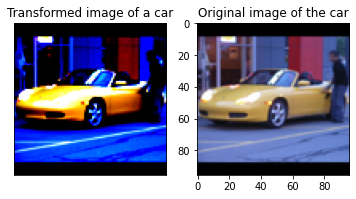

In [7]:
index = 1

image, label = train_dataset[index]
image = image.permute(1,2,0)

plt.subplot(1, 2, 1, xticks=[], yticks=[])
plt.imshow(image)
plt.title('Transformed image of a {}'.format(class_names[label]));

image = image*torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Original image of the {}'.format(class_names[label]));

In [8]:
batch_size = 10

dataloader_train = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=batch_size,
                                               shuffle=True)

dataloader_test = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=batch_size,
                                               shuffle=True)

print('Number of created training batches = ', len(dataloader_train))
print('Number of created test batches =', len(dataloader_test))

Number of created training batches =  500
Number of created test batches = 800


# Data Visualization

In [9]:
class_names = train_dataset.class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(images):
        plt.subplot(2, 5, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] == labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    
    plt.tight_layout()
    plt.show()

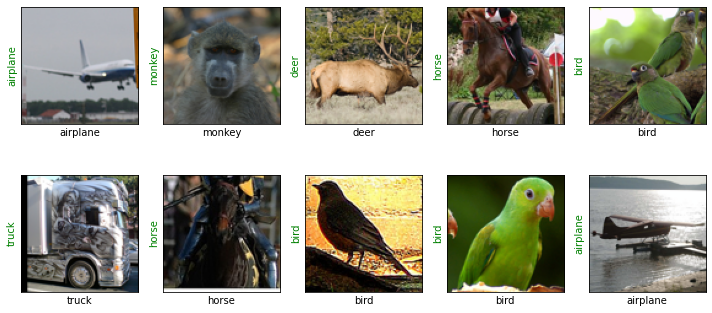

In [10]:
images, labels = next(iter(dataloader_train))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)
#print(resnet18)

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=10)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

/usr/local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


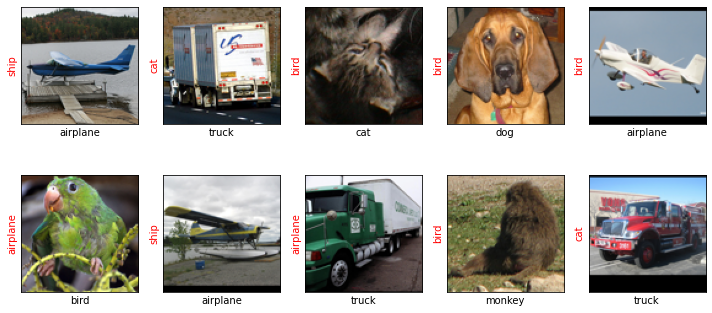

In [14]:
show_preds()

# Train the model

In [15]:
train_loss_array = np.array([])
train_accu_array = np.array([])
valid_loss_array = np.array([])
valid_accu_array = np.array([])
train_step_array = np.array([])
confusion_matrix = np.zeros((num_classes, num_classes))

epochs=1

print('Starting training!')

for e in range(0, epochs):
    print('='*20)
    print(f'Starting epoch {e+1}/{epochs}')
    print('='*20)

    train_accu = 0.
    train_loss = 0.   
    resnet18.train()

    for train_step, (images, labels) in enumerate(dataloader_train):  
        if train_step+1 == len(dataloader_train):
            last_step = True
        else:
            last_step = False
            
        optimizer.zero_grad()
        outputs = resnet18(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        if (train_step % 100 == 0) or (last_step):
            print('='*20)
            print(f'Evaluating at step {train_step}/'+str(len(dataloader_train)))          
            train_step_array = np.append(train_step_array, train_step)
            
            for (images, labels) in tqdm(dataloader_train):
                outputs = resnet18(images)
                loss = loss_function(outputs, labels)
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_accu += sum((preds == labels).numpy())
            
            train_loss /= len(train_dataset)
            train_accu /= len(train_dataset)
            train_loss_array = np.append(train_loss_array, train_loss)
            train_accu_array = np.append(train_accu_array, train_accu)
            print(f'Train loss: {train_loss:.4f}, Train Accuracy: {train_accu:.4f}')

            val_accu = 0.
            val_loss = 0.
            resnet18.eval()

            for (images, labels) in tqdm(dataloader_test):            
                outputs = resnet18(images)
                loss = loss_function(outputs, labels)
                val_loss += loss.item()            
                _, preds = torch.max(outputs, 1)
                val_accu += sum((preds == labels).numpy())
                if (last_step):
                    for p, t in zip(preds, labels):
                        confusion_matrix[p, t] += 1
                    
            val_loss /= len(test_dataset)
            val_accu /= len(test_dataset)
            valid_loss_array = np.append(valid_loss_array, val_loss)
            valid_accu_array = np.append(valid_accu_array, val_accu)
            print(f'Validation loss: {val_loss:.4f}, Validation Accuracy: {val_accu:.4f}')
            
            resnet18.train()

        if val_accu > 0.95:
            print('Performance condition satisfied!')
            break
   

Starting training!
Starting epoch 1/1
Evaluating at step 0/500


100%|██████████| 500/500 [01:30<00:00,  5.52it/s]


Train loss: 0.2686, Train Accuracy: 0.0948


100%|██████████| 800/800 [02:10<00:00,  6.13it/s]


Validation loss: 0.2878, Validation Accuracy: 0.0894
Evaluating at step 100/500


100%|██████████| 500/500 [01:29<00:00,  5.59it/s]


Train loss: 0.1273, Train Accuracy: 0.6168


100%|██████████| 800/800 [02:16<00:00,  5.86it/s]


Validation loss: 0.1178, Validation Accuracy: 0.6539
Evaluating at step 200/500


100%|██████████| 500/500 [01:31<00:00,  5.45it/s]


Train loss: 0.0863, Train Accuracy: 0.7339


100%|██████████| 800/800 [02:16<00:00,  5.87it/s]


Validation loss: 0.0763, Validation Accuracy: 0.7714
Evaluating at step 300/500


100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


Train loss: 0.0686, Train Accuracy: 0.7969


100%|██████████| 800/800 [02:15<00:00,  5.91it/s]


Validation loss: 0.0631, Validation Accuracy: 0.7989
Evaluating at step 400/500


100%|██████████| 500/500 [01:31<00:00,  5.49it/s]


Train loss: 0.0586, Train Accuracy: 0.8140


100%|██████████| 800/800 [02:14<00:00,  5.93it/s]


Validation loss: 0.0551, Validation Accuracy: 0.8183
Evaluating at step 499/500


100%|██████████| 500/500 [01:31<00:00,  5.47it/s]


Train loss: 0.0497, Train Accuracy: 0.8462


100%|██████████| 800/800 [02:15<00:00,  5.92it/s]

Validation loss: 0.0501, Validation Accuracy: 0.8324


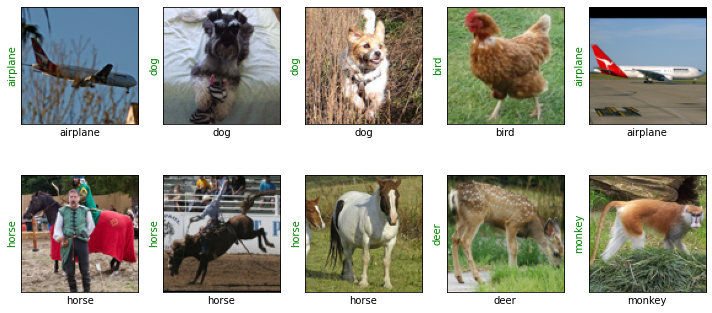

In [16]:
show_preds()

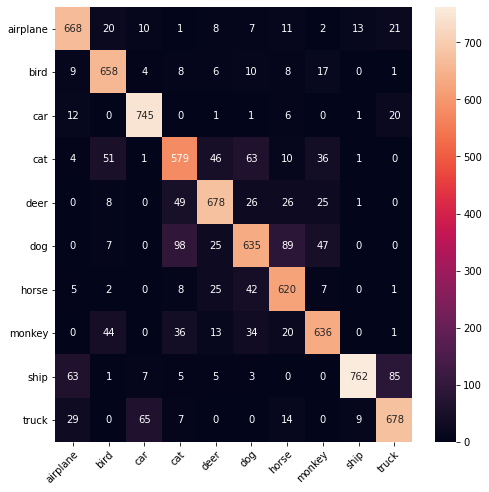

In [17]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
sns.heatmap(confusion_matrix, annot=True, xticklabels=True, yticklabels=True, fmt='g')
ax.set_xticklabels(class_names);
ax.set_yticklabels(class_names);
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor");
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",
        rotation_mode="anchor");
plt.show()

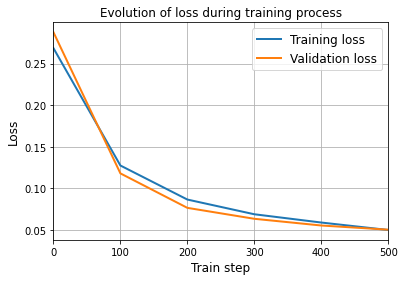

No handles with labels found to put in legend.


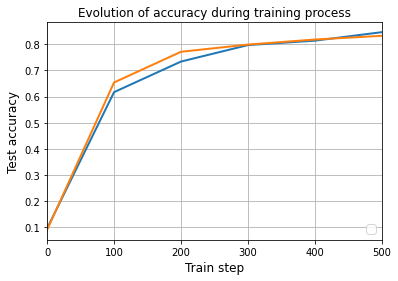

In [19]:
plt.figure()
plt.xlim([0, len(dataloader_train)])
plt.plot(train_step_array, train_loss_array, lw=2, label='Training loss')
plt.plot(train_step_array, valid_loss_array, lw=2, label='Validation loss')
plt.xlabel('Train step', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Evolution of loss during training process', fontsize=12)
plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.show()

plt.figure()
plt.xlim([0, len(dataloader_train)])
plt.plot(train_step_array, train_accu_array, lw=2)
plt.plot(train_step_array, valid_accu_array, lw=2)
plt.xlabel('Train step', fontsize=12)
plt.ylabel('Test accuracy', fontsize=12)
plt.title('Evolution of accuracy during training process', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show() 
